In [114]:
import sys; sys.path.append('..'); from wwa import *


xn,xx,yn,yx = [27,41,-12,2]
mapproj = cartopy.crs.PlateCarree()

sf = gpd.read_file("sf")

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/"

# Linear trend in rx30day
Should only be used for quick comparison - final version should use the fitted GEV & give return periods

In [64]:
def qfit(x):
    
    gmst = pd.read_csv("data/gmst.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = 0).to_xarray().gmst
    x = x.assign_coords(time = gmst.sel(year = x.time.dt.year)).rename(time = "gmst")
    
    lfit = x.polyfit("gmst", deg = 1).polyfit_coefficients
    lfitted = xr.polyval(x.gmst, lfit)
    
    lres = x - lfitted
    
    return {"coef" : lfit, "fitted" : lfitted, "res" : lres}


In [153]:
ndays = 60

datasets = ["cpc", "mswep", "chirps", "tamsat"]
obs = {ds : xr.open_dataset("data/rx"+str(ndays)+"day-MAM_gridded_"+ds+".nc").pr for ds in datasets}
lfits = {ds : qfit(obs[ds]) for ds in datasets}

## Linear association with GMST

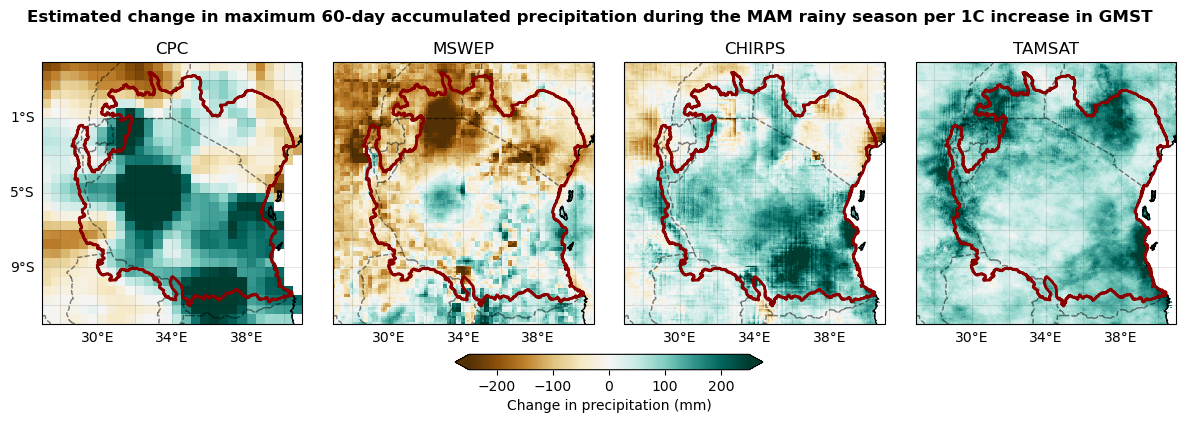

In [154]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01)

v = 250

for i in range(4):
    ds = datasets[i]
    da = lfits[ds]["coef"].sel(degree = 1)
    ax = axs[i]
    
    cbar = da.plot(ax = ax, cmap = "BrBG", vmin = -v, vmax = v, add_colorbar = False)
    ax.set_title(ds.upper())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
    
axs[0].gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])

plt.colorbar(cbar, ax = axs, location = "bottom", label = "Change in precipitation (mm)", fraction = 0.05, pad = 0.1, extend = "both")
plt.suptitle("Estimated change in maximum "+str(ndays)+"-day accumulated precipitation during the MAM rainy season per 1C increase in GMST", fontweight = "bold", y = 1.01)

plt.savefig("fig/rx"+str(ndays)+"day_gridded-fit_linear-trend.png")

## 2024 event

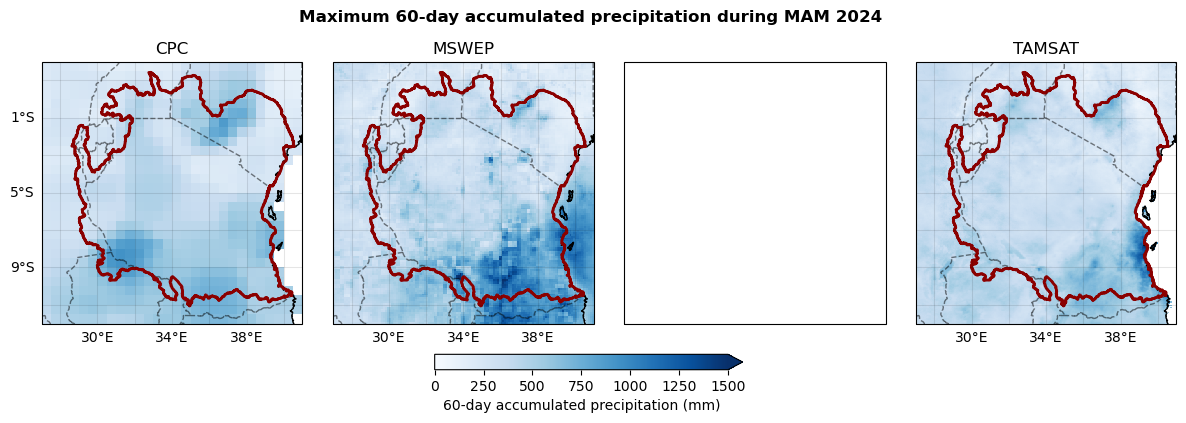

In [155]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01)


v = {"30" : 750, "60" : 1500}[str(ndays)]

for i in range(4):
    ds = datasets[i]
    if ds == "chirps": continue
    da = obs[ds].sel(time = "2024")
    ax = axs[i]
    
    cbar = da.plot(ax = ax, vmin = 0, vmax = v, cmap = "Blues", add_colorbar = False)
    ax.set_title(ds.upper())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
    
axs[0].gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])

plt.suptitle("Maximum "+str(ndays)+"-day accumulated precipitation during MAM 2024", fontweight = "bold", y = 1.01)
plt.colorbar(cbar, ax = axs, location = "bottom", label = str(ndays)+"-day accumulated precipitation (mm)", fraction = 0.05, pad = 0.1, extend = "max")

plt.savefig("fig/rx"+str(ndays)+"day_gridded-fit_2024-accumulation.png")

## 2024 anomaly

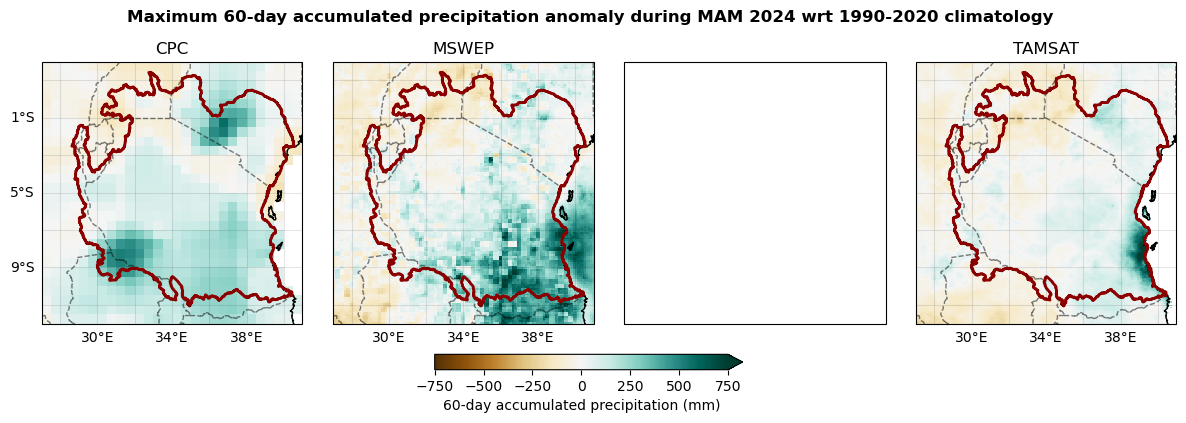

In [156]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01)


v = {"30" : 500, "60" : 750}[str(ndays)]

for i in range(4):
    ds = datasets[i]
    if ds == "chirps": continue
    da = obs[ds].sel(time = "2024") - obs[ds].sel(time = slice("1990", "2020")).mean("time")
    ax = axs[i]
    
    cbar = da.plot(ax = ax, cmap = "BrBG", add_colorbar = False, vmin = -v, vmax = v)
    ax.set_title(ds.upper())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
    
axs[0].gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])

plt.suptitle("Maximum "+str(ndays)+"-day accumulated precipitation anomaly during MAM 2024 wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)
plt.colorbar(cbar, ax = axs, location = "bottom", label = str(ndays)+"-day accumulated precipitation (mm)", fraction = 0.05, pad = 0.1, extend = "max")

plt.savefig("fig/rx"+str(ndays)+"day_gridded-fit_2024-anomaly.png")